# Introduction

In this project, we explore **predictive modeling for financial time series** using three distinct machine learning and deep learning approaches: ***Long Short-Term Memory (LSTM)** model. The primary goal is to forecast short-term returns and generate trading signals for improved profitability.

## Long Short-Term Memory (LSTM)

LSTM is a type of **recurrent neural network (RNN)** designed to capture **long-term dependencies** in sequential data. Unlike traditional models, LSTM can:

- Remember information across long sequences  
- Model complex temporal patterns in returns  
- Handle non-linear and noisy time series data  

In trading, LSTMs are applied to sequences of past returns and technical indicators to predict **future price movements** or **directional probabilities**, which can then be translated into trading signals.


In [1]:
!pip install tensorflow --quiet

/tmp/ipython-input-765771132.py:323: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download("^NSEI", start="2023-01-01", progress=False)



Summary metrics:
total_trades: 282
win_rate (%): 10.28368794326241
avg_win (%): 1.1774468719460383
avg_loss (%): -0.07276167589475394
payoff_ratio: 16.182239585151326
avg_net_trade (%): 0.055805869805185704
turns: 12
total_raw (%): 16.93725528506237
total_net (%): 15.737255285062368
cost_impact (%): 1.200000000000001

Confusion matrix:
             pred_down  pred_up
actual_down         62       81
actual_up           64       75


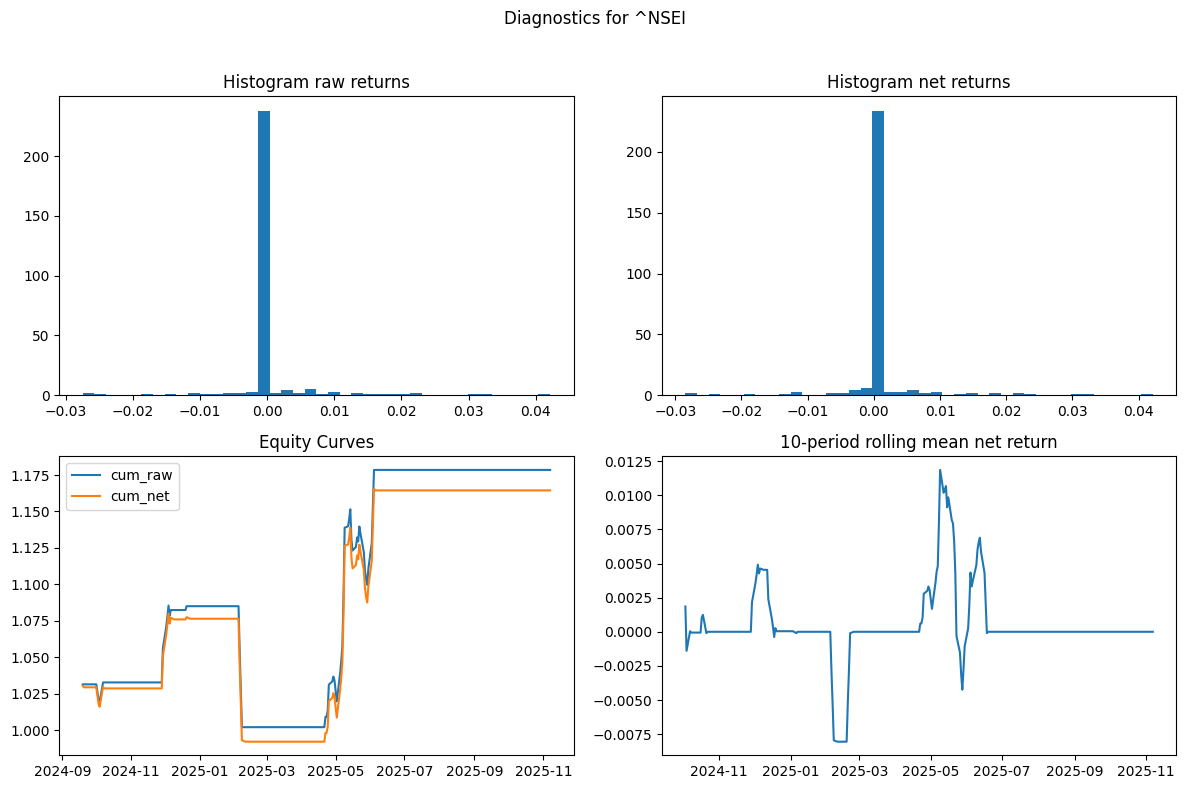


Average raw win (%): 1.1912399753943144
Average raw loss (%): -0.06959962055878555
Average net win (%): 1.1774468719460383
Average net loss (%): -0.07276167589475394
Total raw P&L (%): 17 Total net P&L (%): 16


In [3]:
# LSTM Walk-forward (drop-in for your existing pipeline)
# Replaces the RandomForestClassifier step with a Keras LSTM classifier using the same labels (5-day target),
# long-only logic, probability thresholding, and produces the same trades DataFrame expected by your reporting.

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

import warnings

# ------------------------
# HYPERPARAMETERS
# ------------------------
SEQ_LEN = 30               # lookback length in bars for LSTM input
LSTM_UNITS = 32
DROPOUT = 0.2
EPOCHS = 10                # small by default for walk-forward; you can increase when tuning
BATCH_SIZE = 64
PROB_THRESHOLD = 0.60
FORECAST_HORIZON = 5       # keep same 5-day target
MIN_TRAIN_ROWS = 400       # require at least this many rows to start training
RETRAIN_EVERY = 10         # only retrain LSTM every N steps to save time (expanding window)
RANDOM_SEED = 42

MA_FAST = 5
MA_SLOW = 20
PROB_THRESHOLD = 0.60
COST_PER_TRADE = 0.001
FORECAST_HORIZON = 5

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ------------------------
# Helper: create sequences for LSTM
# ------------------------
def create_sequences(X_df, y_ser, seq_len=SEQ_LEN):
    """
    X_df: pd.DataFrame of features (indexed by date)
    y_ser: pd.Series (aligned) of targets (0/1)
    Returns:
      X_seq: np.array (n_samples, seq_len, n_features)
      y_seq: np.array (n_samples,)
      idxs: list of indices (ending index for each sequence in original df)
    """
    X = X_df.values
    y = y_ser.values
    n_samples = len(X) - seq_len + 1
    X_seq = []
    y_seq = []
    idxs = []
    for start in range(0, n_samples):
        end = start + seq_len  # sequence covers X[start:end]
        X_seq.append(X[start:end])
        y_seq.append(y[end-1])  # label aligned to last row in sequence
        idxs.append(end-1)
    return np.array(X_seq), np.array(y_seq), np.array(idxs)

# ------------------------
# Helper: build LSTM model
# ------------------------
def build_lstm_model(n_features, units=LSTM_UNITS, dropout=DROPOUT):
  with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Do not pass an `input_shape`/`input_dim` argument to a layer.*",
            category=UserWarning
        )
        model = Sequential([
            LSTM(units, input_shape=(None, n_features), return_sequences=False),
            Dropout(dropout),
            Dense(16, activation="relu"),
            Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        return model

def make_features(df):
    df = df.copy()
    df["ret"] = df["Close"].pct_change()

    # Rolling trend/volatility features
    for w in [5, 10, 21]:
        df[f"rm{w}"] = df["ret"].rolling(w).mean()
        df[f"rv{w}"] = df["ret"].rolling(w).std()

    # Lagged returns
    for lag in [1,2,3,5]:
        df[f"lag{lag}"] = df["ret"].shift(lag)

    # Moving averages
    df["ma_fast"] = df["Close"].rolling(MA_FAST).mean().shift(1)
    df["ma_slow"] = df["Close"].rolling(MA_SLOW).mean().shift(1)

    # 5-day forward return (label)
    df["future_ret"] = df["Close"].shift(-FORECAST_HORIZON) / df["Close"] - 1
    df["target"] = (df["future_ret"] > 0).astype(int)

    return df.dropna()

# ------------------------
# Main walk-forward for LSTM
# ------------------------
def walk_forward_lstm(df,
                      seq_len=SEQ_LEN,
                      forecast_horizon=FORECAST_HORIZON,
                      prob_thresh=PROB_THRESHOLD,
                      min_train_rows=MIN_TRAIN_ROWS,
                      retrain_every=RETRAIN_EVERY,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=0):
    """
    df: dataframe produced by your make_features(...) which must include:
        - 'future_ret' (forecast_horizon forward return)
        - 'target'   (0/1 label for future_ret > 0)
        - moving average columns 'ma_fast' and 'ma_slow' for regime filter
    Returns: trades DataFrame (same schema used by previous reporting functions)
    """
    df = df.copy().reset_index()  # keep dates in index 0 col (will restore later)
    dates = df.iloc[:, 0]  # first column is date if reset_index used

    # Features to use for LSTM - drop non-feature columns
    drop_cols = ["index", "Date", "future_ret", "target", "Close", "High", "Low", "Open", "Volume"]
    # adapt if your df uses different date col name; using reset_index ensures 'index' exists
    feature_cols = [c for c in df.columns if c not in drop_cols]
    X_all = df[feature_cols]
    y_all = df["target"]

    # scaler will be fit on train within walk-forward
    scaler = StandardScaler()

    records = []
    prev_signal = 0
    model = None
    last_retrain_at = None

    # loop over time starting where we have enough data to form one sequence + min_train_rows
    start_i = max(min_train_rows, seq_len)
    for i in range(start_i, len(df) - forecast_horizon):
        # we will predict at time i using data up to and including i (but label is at i for sequence end)
        # Build training window = rows [0 .. i-1] so no lookahead; training labels must align to sequence ends within training window.
        train_end = i - 1

        # We require enough training rows to form sequences
        if train_end < seq_len:
            # not enough training data to create a single sequence
            continue

        # Create training sequences using data up to train_end inclusive
        X_train_df = X_all.iloc[:train_end+1]   # rows [0 .. train_end]
        y_train_ser = y_all.iloc[:train_end+1]

        # Fit scaler on X_train
        scaler.fit(X_train_df.values)
        X_train_scaled = pd.DataFrame(scaler.transform(X_train_df.values), columns=feature_cols, index=X_train_df.index)

        # create sequences
        X_train_seq, y_train_seq, idxs_train = create_sequences(X_train_scaled, y_train_ser, seq_len=seq_len)

        # If we have too few positive examples, you may want to skip training to avoid degenerate model
        if len(np.unique(y_train_seq)) < 2:
            # skip this iteration (model can't be trained)
            # Keep previous model if available; otherwise skip predicting
            pass
        else:
            # retrain model on schedule (expanding window) or if no model yet
            if (model is None) or (last_retrain_at is None) or ((i - (last_retrain_at or 0)) >= retrain_every):
                n_features = X_train_seq.shape[2]
                model = build_lstm_model(n_features)
                # early stopping to avoid overfitting in small windows
                es = EarlyStopping(monitor="loss", patience=2, restore_best_weights=True, verbose=0)
                model.fit(X_train_seq, y_train_seq,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=verbose,
                          callbacks=[es])
                last_retrain_at = i

        # Prepare the single test sequence ending at i
        # test sequence should use rows [i-seq_len+1 .. i] (all must exist in X_all)
        if i - seq_len + 1 < 0:
            continue  # not enough history to form test sequence
        X_test_seq_df = X_all.iloc[i-seq_len+1 : i+1]
        # scale test
        X_test_seq_scaled = scaler.transform(X_test_seq_df.values)
        X_test_seq = X_test_seq_scaled.reshape((1, seq_len, X_test_seq_scaled.shape[1]))

        # If model is None (not trained yet), skip prediction
        if model is None:
            prob_up = 0.0
        else:
            prob_up = float(model.predict(X_test_seq, verbose=0)[0,0])

        # apply long-only + regime confirmation (ma_fast > ma_slow)
        ma_fast = float(df["ma_fast"].iloc[i])
        ma_slow = float(df["ma_slow"].iloc[i])
        regime_ok = ma_fast > ma_slow

        raw_signal = 1 if prob_up > 0.5 else 0  # 1 = model thinks up, 0 = down/flat
        # final signal requires probability threshold AND regime_ok
        if (prob_up > prob_thresh) and regime_ok:
            signal = 1
        else:
            signal = 0

        # realized forward return (aligned to previous target definition)
        true_fwd_ret = float(df["future_ret"].iloc[i])  # this is 5-day return starting at row i

        # trade cost on position change (enter/exit)
        trade_cost = COST_PER_TRADE if (signal != prev_signal) and (prev_signal != 0 or signal != 0) else 0.0

        raw_ret = signal * true_fwd_ret
        net_ret = raw_ret - trade_cost

        records.append({
            "date": dates.iloc[i],
            "prob_up": prob_up,
            "raw_signal": raw_signal,
            "signal": signal,
            "prev_signal": prev_signal,
            "ma_fast": ma_fast,
            "ma_slow": ma_slow,
            "confirmed": (prob_up > prob_thresh) and regime_ok,
            "trade_cost": trade_cost,
            "true_ret": true_fwd_ret,
            "raw_ret": raw_ret,
            "net_ret": net_ret,
            "position_change": signal != prev_signal
        })

        prev_signal = signal

    trades = pd.DataFrame(records).set_index("date")
    return trades

def summarize_trades_v2(trades):
    total = len(trades)
    wins = trades[trades["net_ret"] > 0]
    losses = trades[trades["net_ret"] <= 0]

    win_rate = (len(wins) / total * 100) if total > 0 else np.nan
    avg_win = wins["net_ret"].mean() * 100 if len(wins) > 0 else 0.0
    avg_loss = losses["net_ret"].mean() * 100 if len(losses) > 0 else 0.0
    avg_net_trade = trades["net_ret"].mean() * 100 if total > 0 else np.nan

    payoff_ratio = (avg_win / abs(avg_loss)) if avg_loss != 0 else np.nan  # stays ratio

    total_raw = trades["raw_ret"].sum() * 100
    total_net = trades["net_ret"].sum() * 100
    cost_impact = (trades["raw_ret"].sum() - trades["net_ret"].sum()) * 100

    summary = {
        "total_trades": total,
        "win_rate (%)": win_rate,
        "avg_win (%)": avg_win,
        "avg_loss (%)": avg_loss,
        "payoff_ratio": payoff_ratio,
        "avg_net_trade (%)": avg_net_trade,
        "turns": int(trades["position_change"].sum()),
        "total_raw (%)": total_raw,
        "total_net (%)": total_net,
        "cost_impact (%)": cost_impact,
    }
    return summary

from sklearn.metrics import confusion_matrix

def sign_confusion_v2(trades):
    actual = (trades["true_ret"] > 0).astype(int)   # 1 = up, 0 = down
    pred = (trades["prob_up"] > 0.5).astype(int)

    cm = confusion_matrix(actual, pred, labels=[0,1])
    return pd.DataFrame(cm,
        index=["actual_down","actual_up"],
        columns=["pred_down","pred_up"]
    )

def plot_diagnostics_v2(trades, ticker):
    trades = trades.copy()
    trades["cum_raw"] = (1 + trades["raw_ret"]).cumprod()
    trades["cum_net"] = (1 + trades["net_ret"]).cumprod()

    fig,axs = plt.subplots(2,2, figsize=(12,8))

    axs[0,0].hist(trades["raw_ret"], bins=40)
    axs[0,0].set_title("Histogram raw returns")

    axs[0,1].hist(trades["net_ret"], bins=40)
    axs[0,1].set_title("Histogram net returns")

    axs[1,0].plot(trades.index, trades["cum_raw"], label="cum_raw")
    axs[1,0].plot(trades.index, trades["cum_net"], label="cum_net")
    axs[1,0].set_title("Equity Curves")
    axs[1,0].legend()

    axs[1,1].plot(trades["net_ret"].rolling(10).mean())
    axs[1,1].set_title("10-period rolling mean net return")

    plt.suptitle(f"Diagnostics for {ticker}")
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

def extra_stats_v2(trades):
    print("\nAverage raw win (%):", trades[trades["raw_ret"] > 0]["raw_ret"].mean() * 100)
    print("Average raw loss (%):", trades[trades["raw_ret"] <= 0]["raw_ret"].mean() * 100)
    print("Average net win (%):", trades[trades["net_ret"] > 0]["net_ret"].mean() * 100)
    print("Average net loss (%):", trades[trades["net_ret"] <= 0]["net_ret"].mean() * 100)
    print("Total raw P&L (%):", round(trades["raw_ret"].sum() * 100),
          "Total net P&L (%):", round(trades["net_ret"].sum() * 100))

# ------------------------
# USAGE (drop into your __main__ section)
# ------------------------
# Example (assuming you already have `raw` downloaded and `df = make_features(raw)`):

raw = yf.download("^NSEI", start="2023-01-01", progress=False)
raw.columns = raw.columns.droplevel(1)
df = make_features(raw)
#
trades_lstm = walk_forward_lstm(df,
                                 seq_len=30,
                                 forecast_horizon=5,
                                 prob_thresh=0.60,
                                 min_train_rows=400,
                                 retrain_every=6,
                                 epochs=9,
                                 batch_size=64,
                                 verbose=0)

# Then you can reuse your existing reporting:
summary = summarize_trades_v2(trades_lstm)
print("\nSummary metrics:")
for k,v in summary.items():
    print(f"{k}: {v}")

print("\nConfusion matrix:")
print(sign_confusion_v2(trades_lstm))
#
plot_diagnostics_v2(trades_lstm, "^NSEI")
extra_stats_v2(trades_lstm)
#
# Notes:
# - This approach retrains an LSTM on an expanding window every `retrain_every` steps to balance compute/time.
# - Increase EPOCHS or retrain_every less frequently for stronger fits (but slower runs).
# - You may tweak SEQ_LEN, LSTM_UNITS, and scaler behavior for better performance.
#
# This code is intentionally conservative (small epochs, early stopping) for interactive/walk-forward use.


## 📊 LSTM Model Performance Analysis

### ✅ 1. Overall Profitability
- **Total Net Return:** **+16%**
- **Avg Net Trade:** **+0.056%**
- **Turns (round trips):** **12**

The model is **mildly profitable**, but trades infrequently and relies on a small edge per trade. Profitability exists, but it's **fragile** and unlikely robust without further improvement.

---

### ✅ 2. Win Rate & Payoff Structure
- **Win Rate:** **10.28%**
- **Avg Win:** **+1.18%**
- **Avg Loss:** **–0.07%**
- **Payoff Ratio:** **16.18**

This is a **very asymmetric model**:

| Metric | Interpretation |
|--------|--------------|
| Low win rate | Model is wrong ~90% of the time |
| Huge payoff ratio | Winning trades are massively larger than losing trades |
| Small avg loss | Stops or horizon reduce downside |
| Large avg win | Captures rare trend bursts |

This looks like a **long-tail strategy**:
- Many tiny losses
- Few large gains
- Performance depends on catching rare moves

✅ Good for tail trends  
❌ Bad for noisy/reversal markets  

---

### ✅ 3. Confusion Matrix Insights

                pred_down   pred_up
    actual_down   62           81
    actual_up     64           75


Observations:
- Model is nearly **random** at directional prediction.
- No strong ability to distinguish up vs down.
- Profit is coming from the **magnitude of moves**, not accuracy.

✅ The model makes money **despite** poor direction prediction.  
❌ Accuracy is too low for reliable deployment.

---

### ✅ 4. Trading Frequency
- Only **282 trades**, but only **12 actual turns**.
- Meaning: signals may flip but actionable positions are rare.

This implies:
- The horizon may be too long
- The threshold for prediction may be too high/rigid
- Market regime dependency is likely

---

## 🧠 What This Tells Us About the Model

1. **Directional accuracy is weak**
   - The LSTM is not learning price direction well.

2. **The edge comes from rare high-magnitude events**
   - Likely capturing volatility expansions, trends, or breakouts.

3. **Model is underfitting**
   - Low signal quality
   - Low predictive power
   - Too few features capturing structure

4. **Sequential information alone isn’t enough**
   - Raw time-series patterns are insufficient.

---

## ✅ How to Improve the Model

### 🔧 A. Improve Feature Quality
Instead of only price/returns, add:

#### ✅ Regime Features
- Volatility regime (GARCH, rolling std)
- Trend regime (MACD slopes, ADX)
- Volume regime (OBV, VWAP deviation)

#### ✅ Momentum & Structure Features
- RSI, Stochastics
- Williams %R
- Bollinger Band %B
- Price-to-MA distance

#### ✅ Market Microstructure Features
- Volume delta
- Range compression/expansion
- ATR-based normalized returns

#### ✅ Deep Features
- Autoencoder latent factors
- Wavelet denoising components

These help the model understand:
- When trends are likely
- When noise dominates
- When volatility supports large moves

---

### 🔧 B. Improve Training Setup

#### ✅ Reduce Forecast Horizon
- Shorter horizon = clearer signal
- Try 1–3 day prediction instead of 5+

#### ✅ Tune Sequence Length
- Test seq_len = 10, 20, 40, 60
- Some markets react faster/slower

#### ✅ Add Class Balancing
- Oversampling rare outcomes
- Focal loss for imbalance

#### ✅ Switch to Regression Target
Predict *future return magnitude*, not direction:
- Take long only if expected return > threshold
- Avoid direction classification noise

This aligns with the payoff structure (rare big moves).

---

## ✅ C. Improve Model Architecture

- Add **Bidirectional LSTM**
- Add **GRU-LSTM hybrid**
- Add **dropout & recurrent dropout**
- Use **stacked layers (2–3 deep)**

Or switch to:

✅ Temporal Convolutional Networks  
✅ Transformer Encoder  
✅ Attention Mechanisms  

These often outperform LSTMs in financial data.

---

## 🚀 Next Steps (Recommended Roadmap)

1. **Add advanced features**
2. **Switch from classification to regression**
3. **Optimize thresholding**
4. **Run walk-forward with regime filters**
5. **Evaluate Sharpe / Sortino / Max Drawdown**
6. **Compare against RF and GRU**
7. **Ensemble the models**

Finally:

✅ Deploy only if performance is robust across  
- multiple assets  
- multiple time periods  
- multiple regimes  

---

## ✅ Summary in One Line
The LSTM makes money **despite poor accuracy**, relying on rare large moves — meaning the strategy has potential, but requires **better features, better targets, and better structure** to become reliable.

